In [ ]:
import os
from typing import Dict, List, Optional, Tuple, Callable
from collections import Counter
import time

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, utils
from torchvision.datasets.folder import default_loader
from tqdm import tqdm

In [2]:
def get_compute_device(verbose: bool = True) -> torch.device:
    cuda_available = torch.cuda.is_available()

    if cuda_available:
        try:
            if verbose:
                print(f"[INFO] Используется CUDA-совместимое устройство")
                print(f"├─ Версия CUDA: {torch.version.cuda}")
                print(f"├─ Название GPU: {torch.cuda.get_device_name(0)}")
                print(f"└─ Всего GPU: {torch.cuda.device_count()}")
        except Exception as e:
            print(f"[WARNING] Ошибка при инициализации CUDA: {str(e)}")
    elif verbose:
        print("[INFO] CUDA недоступна, используется CPU")

    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = get_compute_device()

[INFO] Используется CUDA-совместимое устройство
├─ Версия CUDA: 12.8
├─ Название GPU: NVIDIA GeForce RTX 3060 Laptop GPU
└─ Всего GPU: 1


In [3]:
def create_dataframe(folder_path: str) -> pd.DataFrame:
    classes = os.listdir(folder_path)
    filepaths = []
    labels = []

    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if os.path.isfile(img_path):
                    filepaths.append(img_path)
                    labels.append(class_name)

    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

train_df = create_dataframe('train')
test_df = create_dataframe('test')

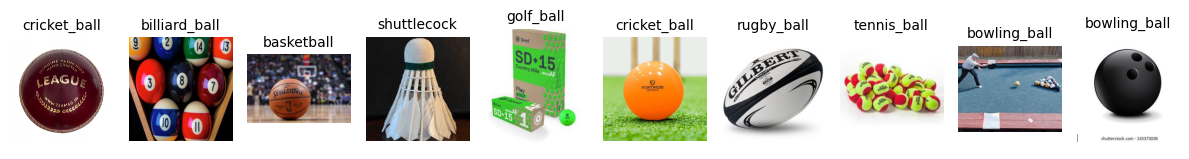

In [4]:
def split_data_with_stratification(df: pd.DataFrame, test_size: float = 0.5, random_state: int = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return train_test_split(df, test_size=test_size, stratify=df['labels'], random_state=random_state)

def visualize_image_samples(df: pd.DataFrame, n_samples: int = 5, figsize: tuple[int, int] = (12, 12)) -> None:
    _, axes = plt.subplots(1, n_samples, figsize=figsize)
    sample_df = df.sample(n=n_samples, random_state=42)

    for idx, (_, row) in enumerate(sample_df.iterrows()):
        img = cv2.cvtColor(cv2.imread(row['filepaths']), cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(row['labels'], fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

test_df, valid_df = split_data_with_stratification(test_df)
visualize_image_samples(train_df, n_samples=10)

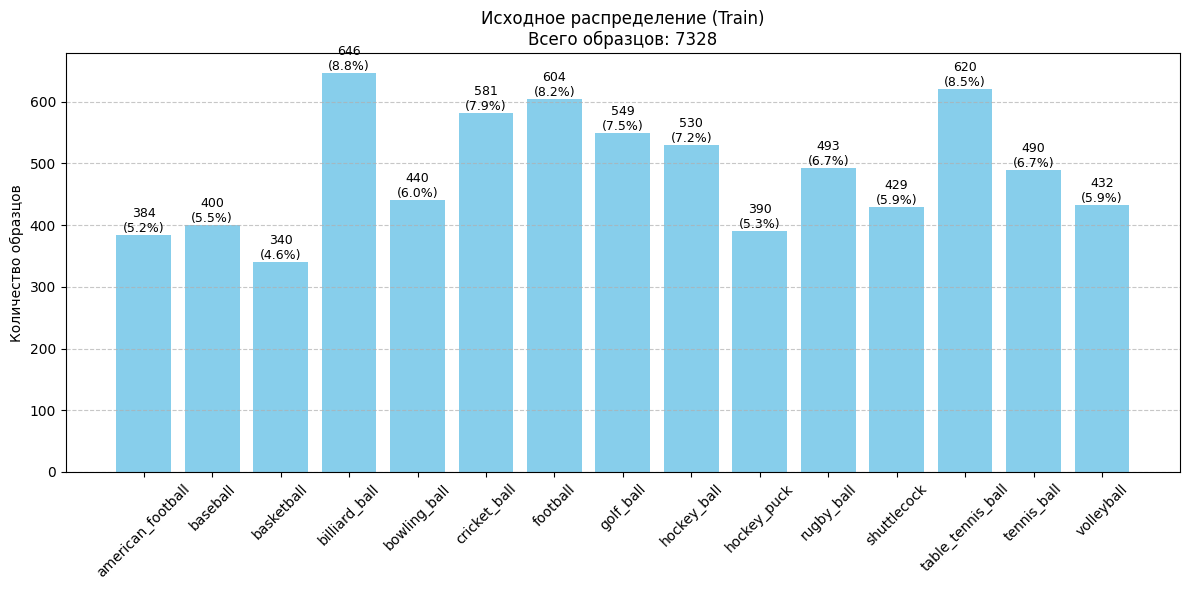

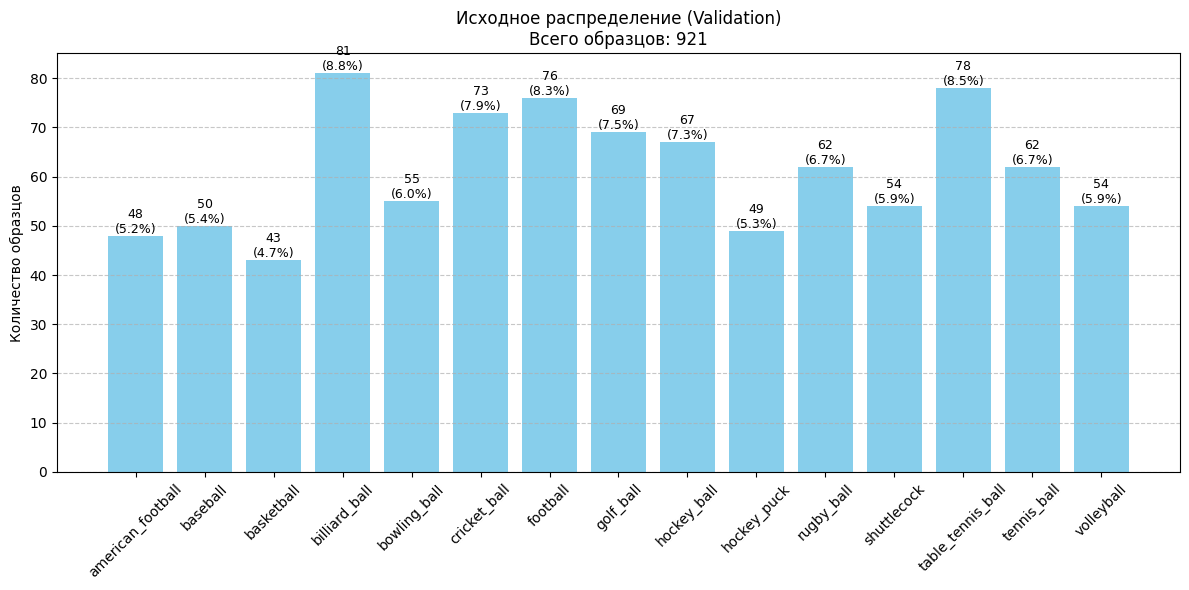

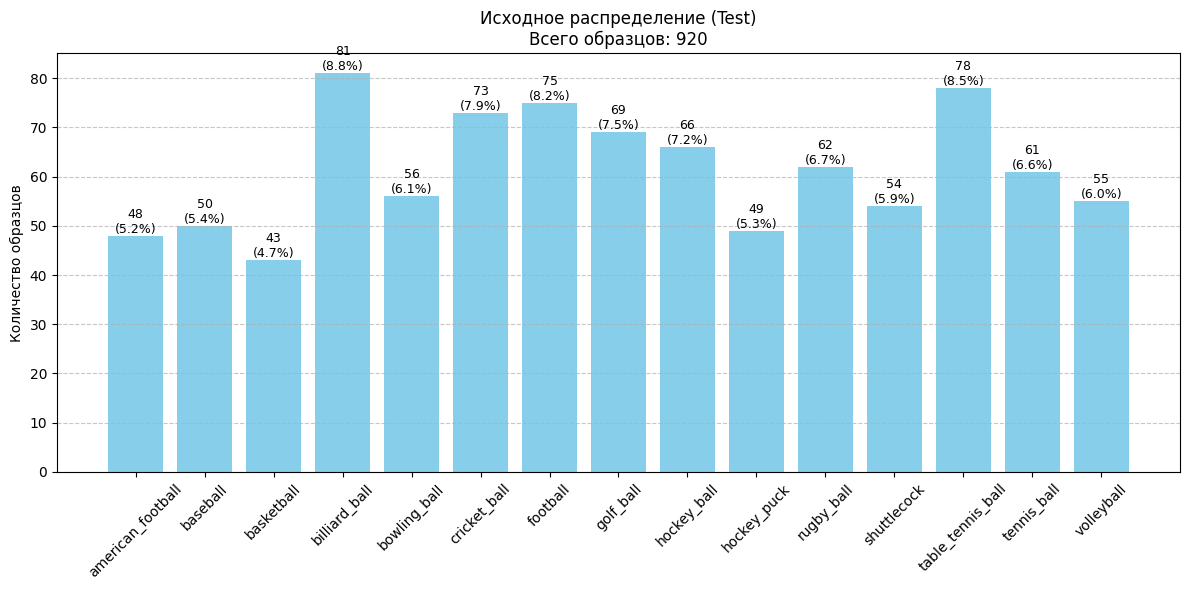

In [5]:
def plot_original_distribution(df: pd.DataFrame, title: str) -> None:
    counts: pd.Series = df['labels'].value_counts().sort_index()
    class_names: list[str] = counts.index.tolist()
    values: np.ndarray = counts.values
    total: int = sum(values)

    plt.figure(figsize=(12, 6))
    bars: plt.BarContainer = plt.bar(class_names, values, color='skyblue')

    for bar in bars:
        height: float = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{int(height)}\n({height/total:.1%})',
            ha='center',
            va='bottom',
            fontsize=9
        )

    plt.title(f'Исходное распределение ({title})\nВсего образцов: {total}')
    plt.xticks(rotation=45)
    plt.ylabel('Количество образцов')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_original_distribution(train_df, "Train")
plot_original_distribution(valid_df, "Validation")
plot_original_distribution(test_df, "Test")

In [6]:
def create_train_transforms(input_size: int = 224,
                          rotation_degrees: int = 15,
                          mean: List[float] = [0.485, 0.456, 0.406],
                          std: List[float] = [0.229, 0.224, 0.225]) -> transforms.Compose:
    return transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.1),
        transforms.RandomRotation(rotation_degrees),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

def create_val_test_transforms(input_size: int = 224,
                               resize_size: int = 256,
                               mean: List[float] = [0.485, 0.456, 0.406],
                               std: List[float] = [0.229, 0.224, 0.225]) -> transforms.Compose:
    return transforms.Compose([
        transforms.Resize(resize_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

train_transform: transforms.Compose = create_train_transforms()
val_test_transform: transforms.Compose = create_val_test_transforms()

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transform: Optional[Callable[[Image.Image], torch.Tensor]] = None):
        self.transform = transform
        self.class_to_idx: Dict[str, int] = {cls: i for i, cls in enumerate(sorted(dataframe['labels'].unique()))}
        self.samples: List[Tuple[str, int]] = [
            (row['filepaths'], self.class_to_idx[row['labels']])
            for _, row in dataframe.iterrows()
            if os.path.exists(row['filepaths'])
        ]

        if len(self.samples) < len(dataframe):
            print(f"Warning: {len(dataframe) - len(self.samples)} files not found")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        path, label = self.samples[idx]
        image = default_loader(path)

        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset: CustomDataset = CustomDataset(train_df, transform=train_transform)
valid_dataset: CustomDataset = CustomDataset(valid_df, transform=val_test_transform)
test_dataset: CustomDataset = CustomDataset(test_df, transform=val_test_transform)

In [8]:
def get_optimal_workers(max_workers=12):
    num_cores = os.cpu_count() or 1
    gpu_count = torch.cuda.device_count()
    return min(num_cores - 2 - gpu_count, max_workers)

def create_loader(dataset: torch.utils.data.Dataset, batch_size: int = 96, shuffle: bool = False, num_workers: Optional[int] = 0,
                  cuda: Optional[bool] = None, persistent_workers: bool = True, balance: bool = False) -> DataLoader:
    if cuda is None:
        cuda = torch.cuda.is_available()

    if num_workers is None:
        num_workers = get_optimal_workers() if cuda else 0

    if persistent_workers and num_workers == 0:
        persistent_workers = False

    if balance:
        labels = np.array([label for _, label in dataset.samples])
        class_counts = np.bincount(labels)

        class_counts = np.maximum(class_counts, 1)

        class_weights = 1.0 / class_counts
        class_weights = class_weights / np.min(class_weights)

        sample_weights = np.clip(class_weights[labels], 0.5, 5.0)

        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(dataset),
            replacement=True
        )
        shuffle = False
    else:
        sampler = None

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=cuda,
        persistent_workers=persistent_workers,
        drop_last=True,
        collate_fn=lambda x: (torch.stack([i[0] for i in x]), torch.tensor([i[1] for i in x])),
    )

cuda = torch.cuda.is_available()

train_loader = create_loader(train_dataset, cuda=cuda, balance=True)
val_loader = create_loader(valid_dataset, shuffle=False, cuda=cuda)
test_loader = create_loader(test_dataset, shuffle=False, cuda=cuda)

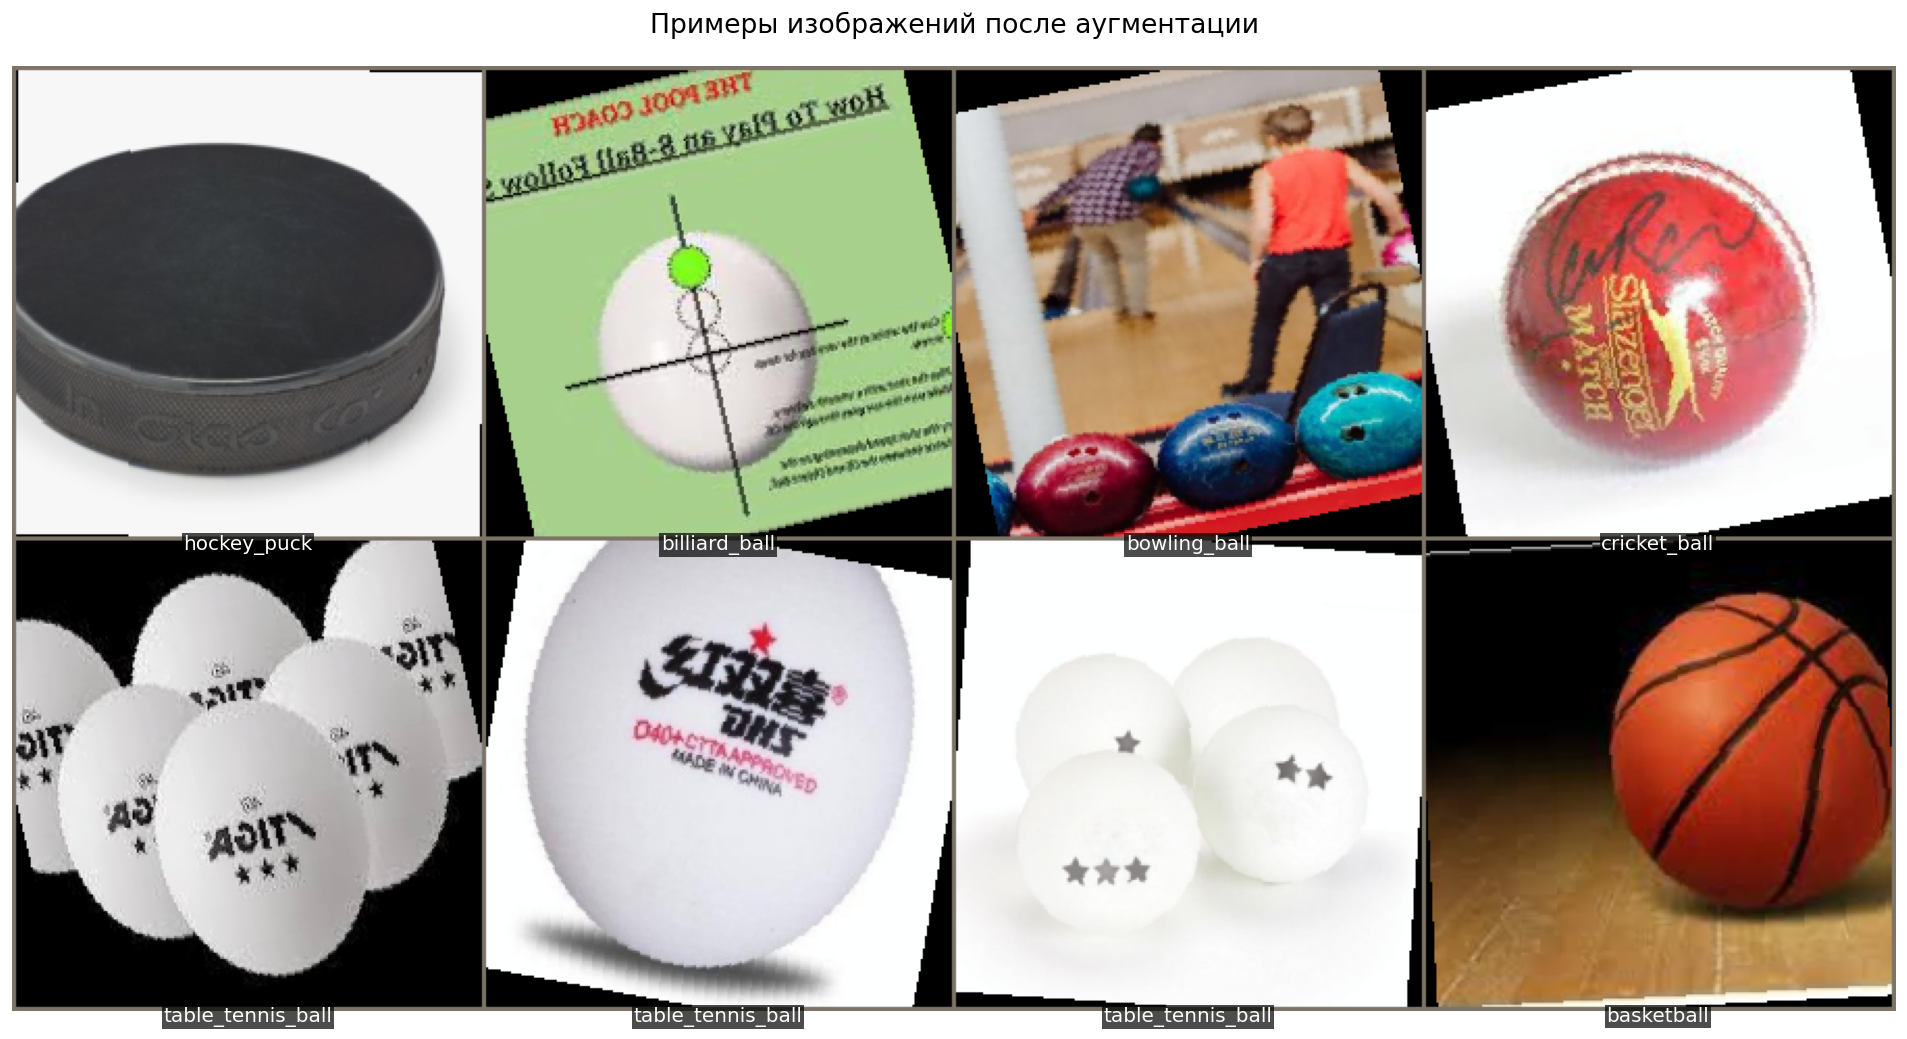

In [9]:
def imshow(inp, labels=None, class_names=None, title=None, figsize=(16, 12), fontsize=12, dpi=100):
    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(inp)

    if labels is not None:
        labels = labels.numpy()[:8]

        if class_names is not None:
            captions = [f"{class_names[label]}" for label in labels]
        else:
            captions = [f"{label}" for label in labels]

        for i, caption in enumerate(captions):
            plt.text(
                (i % 4) * (inp.shape[1] // 4) + (inp.shape[1] // 8),
                (i // 4) * (inp.shape[0] // 2) + (inp.shape[0] // 2 + 5),
                caption,
                ha='center',
                color='white',
                fontsize=fontsize,
                bbox=dict(facecolor='black', alpha=0.7, pad=1, edgecolor='none')
            )

    if title is not None:
        plt.title(title, fontsize=fontsize+4, pad=20)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))
out = utils.make_grid(images[:8], nrow=4)

class_names = {v: k for k, v in train_dataset.class_to_idx.items()}

imshow(out, labels=labels[:8], class_names=class_names,
       title="Примеры изображений после аугментации",
       figsize=(16, 12), fontsize=12, dpi=120)

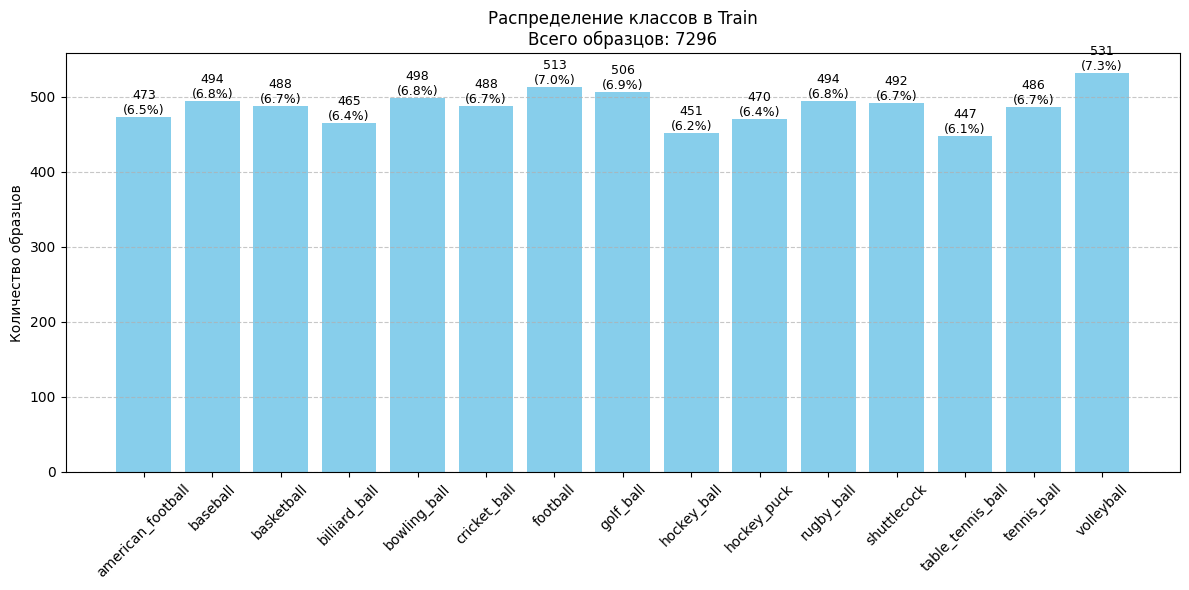

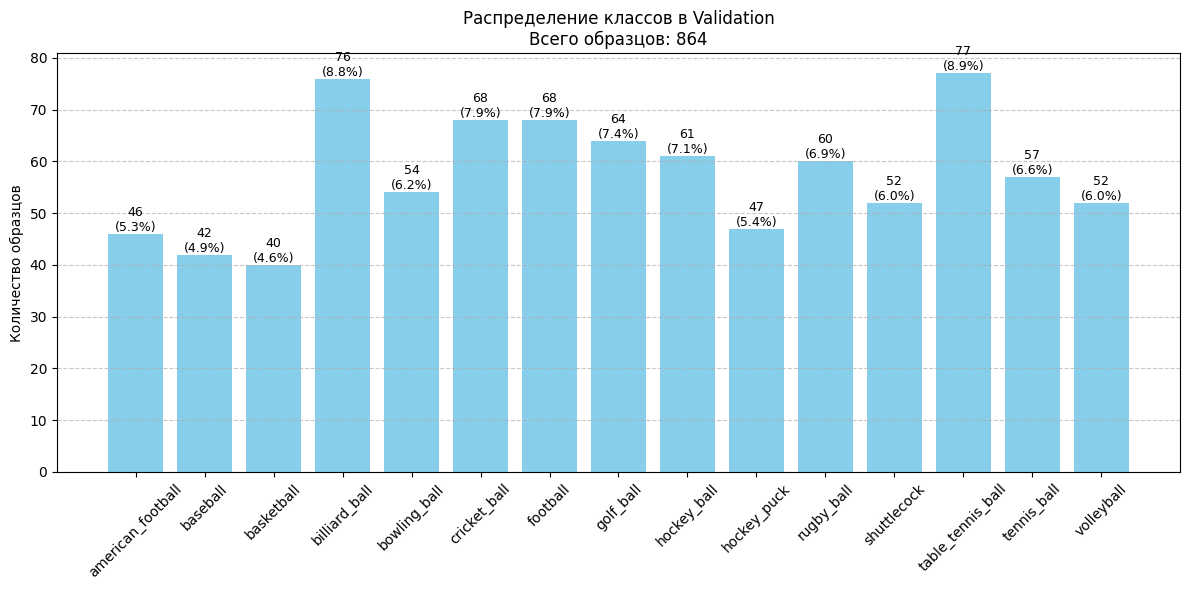

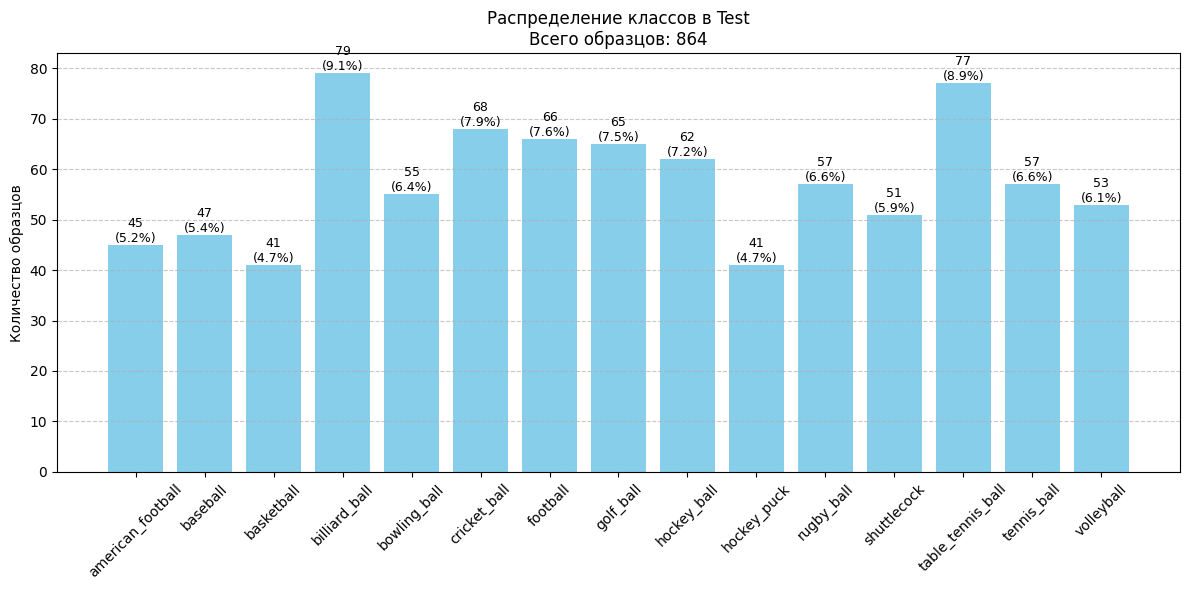

In [10]:
def check_loader_balance(loader: DataLoader, dataset: Dataset, title: str) -> None:
    if hasattr(dataset, 'class_to_idx'):
        idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
        class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
    else:
        class_names = list(map(str, sorted(set(dataset.dataframe['labels']))))

    label_counter = Counter()
    for _, labels in loader:
        if isinstance(labels, torch.Tensor):
            labels = labels.cpu().numpy()
        label_counter.update(labels)

    counts = [label_counter[i] for i in range(len(class_names))]
    total = sum(counts)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names, counts, color='skyblue')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}\n({height/total:.1%})',
                 ha='center', va='bottom', fontsize=9)

    plt.title(f'Распределение классов в {title}\nВсего образцов: {total}')
    plt.xticks(rotation=45)
    plt.ylabel('Количество образцов')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

check_loader_balance(train_loader, train_dataset, "Train")
check_loader_balance(val_loader, valid_dataset, "Validation")
check_loader_balance(test_loader, test_dataset, "Test")

In [ ]:
class MyAlexNet(nn.Module):
    def __init__(self, num_classes: int = 15) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),

            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [12]:
def plot_training_history(history: Dict[str, List[float]]) -> None:
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Val')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
def train(model: nn.Module, optimizer: optim.Optimizer, criterion: nn.Module, epochs: int,
          train_loader: DataLoader, val_loader: DataLoader, device: torch.device, patience: int = 5) -> Dict[str, List[float]]:

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'epoch_times': [], 'lr': [],
        'best_val_loss': float('inf'), 'best_weights': model.state_dict().copy(),
    }

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-8
    )

    scaler = GradScaler()
    patience_counter = 0

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        epoch_train_loss, train_correct = 0.0, 0

        for images, labels in tqdm(train_loader, desc=f'Train Epoch {epoch+1}/{epochs}', leave=False):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            epoch_train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        model.eval()
        val_loss, val_correct = 0.0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Val Epoch {epoch+1}/{epochs}', leave=False):
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = epoch_train_loss / len(train_loader)
        train_acc = 100 * train_correct / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / len(val_loader.dataset)
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        history['epoch_times'].append(time.time() - start_time)

        scheduler.step(val_loss)

        if val_loss < history['best_val_loss']:
            history['best_val_loss'] = val_loss
            history['best_weights'] = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | "
              f"LR: {current_lr:.2e} | Time: {time.time() - start_time:.1f}s")

    model.load_state_dict(history['best_weights'])
    print(f"\nTraining completed. Best Val Loss: {history['best_val_loss']:.4f}")
    return history

In [15]:
model = MyAlexNet(num_classes=15).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [16]:
history = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    epochs=30,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
)

Epoch 1/30: Train Loss: 2.5605 Acc: 21.47% | Val Loss: 2.5799 Acc: 19.65% | LR: 1.00e-03 | Time: 106.1s


Epoch 2/30: Train Loss: 2.3957 Acc: 31.29% | Val Loss: 2.4236 Acc: 28.66% | LR: 1.00e-03 | Time: 87.3s


Epoch 3/30: Train Loss: 2.2900 Acc: 35.93% | Val Loss: 2.3217 Acc: 32.14% | LR: 1.00e-03 | Time: 85.9s


Epoch 4/30: Train Loss: 2.2149 Acc: 39.71% | Val Loss: 2.3704 Acc: 31.60% | LR: 1.00e-03 | Time: 88.7s


Epoch 5/30: Train Loss: 2.1580 Acc: 42.45% | Val Loss: 2.2512 Acc: 37.24% | LR: 1.00e-03 | Time: 89.0s


Epoch 6/30: Train Loss: 2.1058 Acc: 44.91% | Val Loss: 2.1819 Acc: 38.55% | LR: 1.00e-03 | Time: 140.0s


Epoch 7/30: Train Loss: 2.0451 Acc: 47.95% | Val Loss: 2.2195 Acc: 38.76% | LR: 1.00e-03 | Time: 146.5s


Epoch 8/30: Train Loss: 2.0128 Acc: 49.10% | Val Loss: 2.1140 Acc: 43.65% | LR: 1.00e-03 | Time: 134.4s


Epoch 9/30: Train Loss: 1.9641 Acc: 51.98% | Val Loss: 2.1700 Acc: 42.45% | LR: 1.00e-03 | Time: 61.5s


Epoch 10/30: Train Loss: 1.9155 Acc: 53.90% | Val Loss: 2.0776 Acc: 44.41% | LR: 1.00e-03 | Time: 66.6s


Epoch 11/30: Train Loss: 1.8644 Acc: 57.16% | Val Loss: 2.1172 Acc: 45.06% | LR: 1.00e-03 | Time: 86.5s


Epoch 12/30: Train Loss: 1.8439 Acc: 57.97% | Val Loss: 1.9871 Acc: 48.21% | LR: 1.00e-03 | Time: 59.9s


Epoch 13/30: Train Loss: 1.7929 Acc: 60.21% | Val Loss: 2.0247 Acc: 49.62% | LR: 1.00e-03 | Time: 58.7s


Epoch 14/30: Train Loss: 1.7614 Acc: 62.61% | Val Loss: 1.9741 Acc: 52.01% | LR: 1.00e-03 | Time: 56.4s


Epoch 15/30: Train Loss: 1.7364 Acc: 63.78% | Val Loss: 1.9896 Acc: 51.57% | LR: 1.00e-03 | Time: 56.3s


Epoch 16/30: Train Loss: 1.7122 Acc: 65.19% | Val Loss: 1.9791 Acc: 50.92% | LR: 1.00e-03 | Time: 59.5s


Epoch 17/30: Train Loss: 1.6111 Acc: 70.26% | Val Loss: 1.8551 Acc: 54.94% | LR: 5.00e-04 | Time: 55.7s


Epoch 18/30: Train Loss: 1.5591 Acc: 72.91% | Val Loss: 1.8349 Acc: 56.79% | LR: 5.00e-04 | Time: 61.1s


Epoch 19/30: Train Loss: 1.5452 Acc: 74.45% | Val Loss: 1.8146 Acc: 56.89% | LR: 5.00e-04 | Time: 60.2s


Epoch 20/30: Train Loss: 1.5075 Acc: 75.79% | Val Loss: 1.8315 Acc: 57.76% | LR: 5.00e-04 | Time: 58.7s


Epoch 21/30: Train Loss: 1.4871 Acc: 77.31% | Val Loss: 1.7969 Acc: 59.07% | LR: 5.00e-04 | Time: 56.9s


Epoch 22/30: Train Loss: 1.4630 Acc: 78.19% | Val Loss: 1.7635 Acc: 62.21% | LR: 5.00e-04 | Time: 56.2s


Epoch 23/30: Train Loss: 1.4550 Acc: 78.58% | Val Loss: 1.7873 Acc: 59.39% | LR: 5.00e-04 | Time: 54.3s


Epoch 24/30: Train Loss: 1.4279 Acc: 80.27% | Val Loss: 1.7757 Acc: 61.02% | LR: 5.00e-04 | Time: 55.6s


Epoch 25/30: Train Loss: 1.3786 Acc: 83.72% | Val Loss: 1.7055 Acc: 63.74% | LR: 2.50e-04 | Time: 54.0s


Epoch 26/30: Train Loss: 1.3569 Acc: 84.28% | Val Loss: 1.7127 Acc: 63.95% | LR: 2.50e-04 | Time: 56.2s


Epoch 27/30: Train Loss: 1.3356 Acc: 85.93% | Val Loss: 1.6953 Acc: 63.84% | LR: 2.50e-04 | Time: 56.2s


Epoch 28/30: Train Loss: 1.3216 Acc: 86.59% | Val Loss: 1.6692 Acc: 66.12% | LR: 2.50e-04 | Time: 55.2s


Epoch 29/30: Train Loss: 1.3003 Acc: 87.65% | Val Loss: 1.6901 Acc: 64.28% | LR: 2.50e-04 | Time: 54.8s


Epoch 30/30: Train Loss: 1.3038 Acc: 87.62% | Val Loss: 1.6710 Acc: 66.67% | LR: 2.50e-04 | Time: 59.8s

Training completed. Best Val Loss: 1.6692


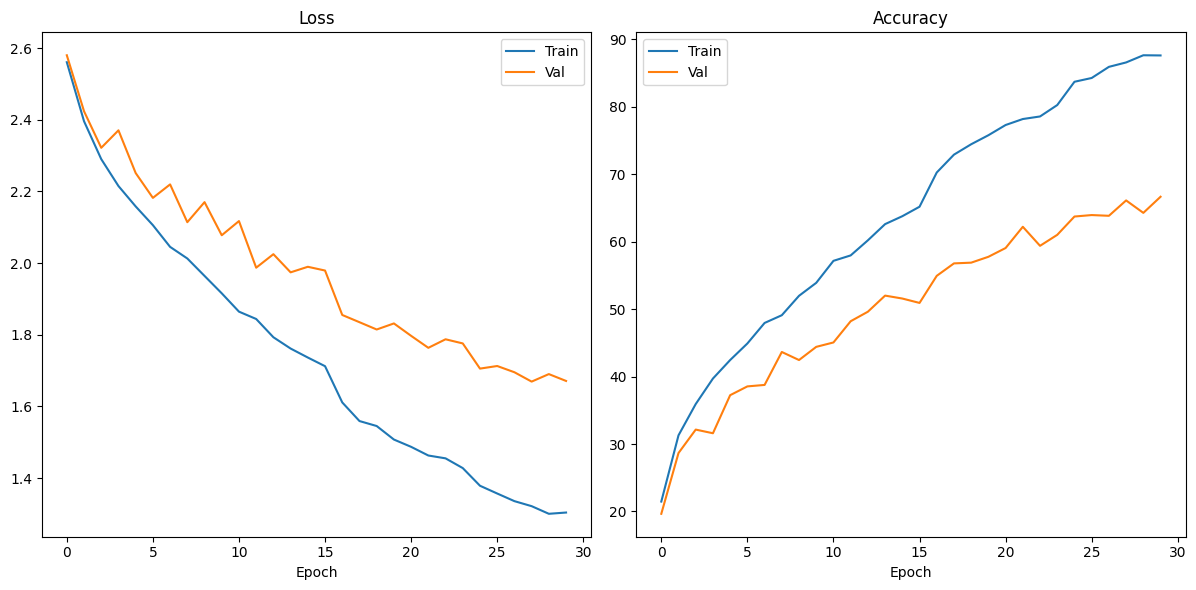

In [17]:
plot_training_history(history=history)

In [18]:
def count_parameters(model: nn.Module) -> None:
    layers: List[Tuple[str, int, str]] = []
    total_trainable: int = 0
    total_frozen: int = 0

    for name, param in model.named_parameters():
        param_count = param.numel()
        if param.requires_grad:
            layers.append((name, param_count, "✓"))
            total_trainable += param_count
        else:
            layers.append((name, param_count, "✗"))
            total_frozen += param_count

    header = [
        "Слой",
        f"Параметры (Всего: {total_trainable + total_frozen:,})",
        "Обучаем"
    ]

    print(tabulate(
        [(name, f"{count:,}", trainable) for name, count, trainable in layers],
        headers=header,
        tablefmt="github",
        stralign="left",
        numalign="right"
    ))

    print(f"\n{' ОБУЧАЕМЫЕ ':=^50}")
    print(f"{total_trainable:,} параметров ({total_trainable/1e6:.2f}M)")
    print(f"{' НЕОБУЧАЕМЫЕ ':=^50}")
    print(f"{total_frozen:,} параметров ({total_frozen/1e6:.2f}M)")

    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    print(f"\n{' РАСПРЕДЕЛЕНИЕ ПАМЯТИ ':=^50}")
    print(f"Параметры: {param_size/1024**2:.2f} MB")
    print(f"Всего памяти: {param_size/1024**2:.2f} MB")

count_parameters(model=model)

| Слой                | Параметры (Всего: 23,534,415)   | Обучаем   |
|---------------------|---------------------------------|-----------|
| features.0.weight   | 34,848                          | ✓         |
| features.0.bias     | 96                              | ✓         |
| features.1.weight   | 96                              | ✓         |
| features.1.bias     | 96                              | ✓         |
| features.4.weight   | 614,400                         | ✓         |
| features.4.bias     | 256                             | ✓         |
| features.5.weight   | 256                             | ✓         |
| features.5.bias     | 256                             | ✓         |
| features.8.weight   | 884,736                         | ✓         |
| features.8.bias     | 384                             | ✓         |
| features.9.weight   | 384                             | ✓         |
| features.9.bias     | 384                             | ✓         |
| features.11.weight


Classification Report:
                   precision    recall  f1-score   support

american_football     0.9688    0.6889    0.8052        45
         baseball     0.6786    0.8085    0.7379        47
       basketball     0.6889    0.7561    0.7209        41
    billiard_ball     0.7949    0.7848    0.7898        79
     bowling_ball     0.5085    0.5455    0.5263        55
     cricket_ball     0.8305    0.7206    0.7717        68
         football     0.6618    0.6818    0.6716        66
        golf_ball     0.6418    0.6615    0.6515        65
      hockey_ball     0.5606    0.5968    0.5781        62
      hockey_puck     0.6042    0.7073    0.6517        41
       rugby_ball     0.7708    0.6491    0.7048        57
      shuttlecock     0.8095    0.6667    0.7312        51
table_tennis_ball     0.7250    0.7532    0.7389        77
      tennis_ball     0.6984    0.7719    0.7333        57
       volleyball     0.7358    0.7358    0.7358        53

         accuracy             

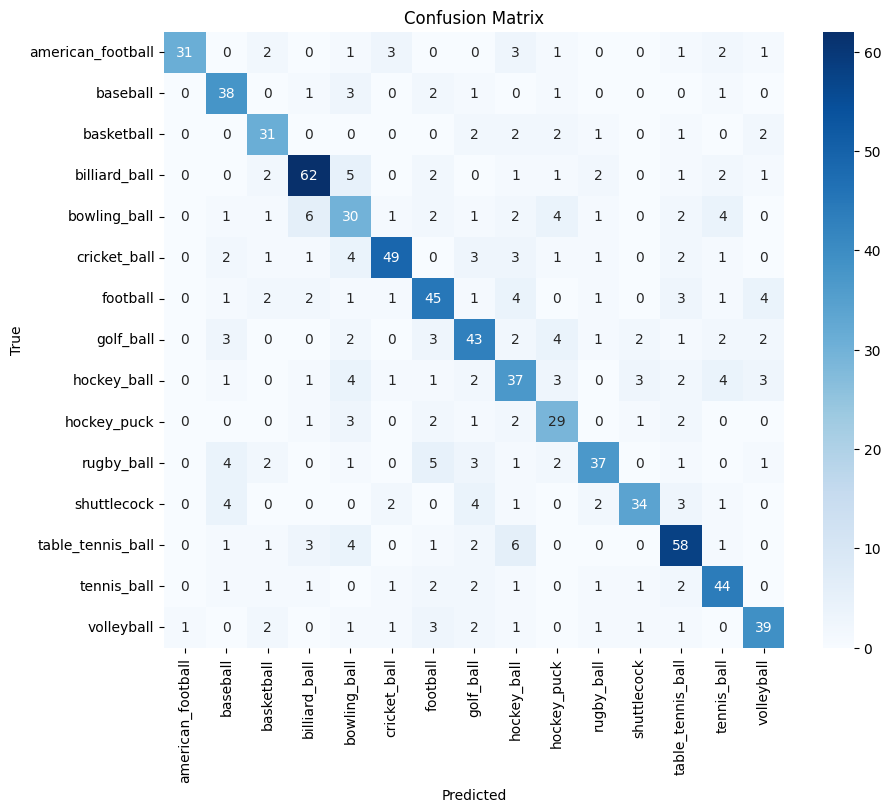

In [19]:
def evaluate(model: torch.nn.Module, test_loader: DataLoader, class_names: List[str], device: torch.device, show_report: bool = True, show_matrix: bool = True) -> dict:
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    metrics = {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'cm': confusion_matrix(all_labels, all_preds)
    }

    if show_report:
        print("\nClassification Report:")
        print(classification_report(metrics['labels'], metrics['predictions'], target_names=class_names, digits=4))

    if show_matrix:
        plt.figure(figsize=(10, 8))
        sns.heatmap(metrics['cm'], annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return metrics

idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

test_metrics = evaluate(model=model,test_loader=test_loader,class_names=class_names,device=device)

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'epoch': len(history['train_loss']),
}, 'checkpoint.pth')